# Классификация токсичности комметариев.

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 1. Подготовка

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import torch
import transformers
from tqdm import notebook
from tqdm import tqdm

import nltk
import re
from nltk.stem import WordNetLemmatizer


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

# модель
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# метрика
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [2]:
# чтение файла и печать общей информации
df_comments = pd.read_csv('/datasets/toxic_comments.csv')

# приведем текст к нижнему регистру
df_comments['text'] = df_comments['text'].str.lower()

#Уменьшим выборку 
df_comments = df_comments.sample(frac=0.6).reset_index(drop=True)

df_comments.head()

,text,toxic
0,we could technically spin off some of the info...,0
1,i am very sorry but i will not be blocked for ...,0
2,"""\n\nwow. a pre-emptive attack on an article i...",0
3,"for your information, the administrator antand...",0
4,full citation\n\ni have deleted the following ...,0


In [3]:
# проверка сбалансированности
m = df_comments['toxic'].value_counts() 
m

0    86001
1     9742
Name: toxic, dtype: int64

Наблюдается ярко выраженный дисбаланс классов.

In [4]:
# формула для уменьшения выборки
from sklearn.utils import resample

df_majority = df_comments[df_comments['toxic'] == 0]
df_minority = df_comments[df_comments['toxic'] == 1]

df_majority_downsampled  = resample(df_majority,
                                    replace=False,
                                    n_samples=m[1],
                                    random_state=123)

df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled['toxic'].value_counts() 

1    9742
0    9742
Name: toxic, dtype: int64

Данные сбалансированны

In [5]:
lemmatizer = WordNetLemmatizer()
tqdm.pandas()

# напишем функцию для лемматизации и очистки текста
def lemm_clear_text(text):
    word_list = nltk.word_tokenize(text) # разбиваем входной текст на токены(слова)
    lemm_text = ' '.join([lemmatizer.lemmatize(w) for w in word_list]) # лемматизируем каждое слово и объединяем в строку
    clear_list = re.sub(r'[^A-Za-z]', ' ', lemm_text) #оставляем только латинские символы
    return " ".join(clear_list.split()) #функция возвращает очищенный и лемматизированный текст в виде строки
 
# применим функцию к нашим комментариям и создадим столбец, хранящий лемматизированные предложения
df_downsampled['lemm_text'] = df_downsampled['text'].progress_apply(lambda x: lemm_clear_text(x))    

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 19484/19484 [00:31<00:00, 622.83it/s]


In [6]:
# проверим на пропуски
df_downsampled.isnull().sum()

text         0
toxic        0
lemm_text    0
dtype: int64

In [7]:
# получим корпус сбалансированных данных 
corpus_downsampled = df_downsampled['lemm_text'].values.astype('U')
target_downsampled = df_downsampled['toxic']

In [8]:
# удалим ненужную и тяжелую переменную
del df_majority
del df_minority
del df_majority_downsampled
del df_downsampled
del df_comments



In [9]:
# разделим данные на тестовую и обучающую выборки
corpus_train, corpus_test, target_train, target_test = train_test_split(corpus_downsampled,
                                                                        target_downsampled,
                                                                        test_size=0.2,
                                                                        random_state=42)
 
# создадим признаки для моделей с момощью TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords as nltk_stopwords


nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(min_df=2, stop_words=stopwords)
count_tf_idf.fit(corpus_train)
 
features_train = count_tf_idf.fit_transform(corpus_train).toarray()
features_test = count_tf_idf.transform(corpus_test).toarray()

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Обучение

In [10]:
# создадим словарь для результатов тестирования
test_score = {}

## 2.1 LogisticRegression

In [11]:
#
model_lr = (LogisticRegression(solver='liblinear', 
                               random_state=42)
            .fit(features_train, target_train)
           )

predictions = model_lr.predict(features_train)
f1_train_lr = f1_score(target_train, predictions)
f1_train_lr


0.9325813221406085

In [12]:
predictions_test = model_lr.predict(features_test)
f1_test_lr = f1_score(target_test, predictions_test)
f1_test_lr

0.8754998667022127

In [13]:
test_score['LogisticRegression'] = [f1_train_lr, f1_test_lr]

## 2.2 CatBoostClassifier

In [14]:
model_cat = CatBoostClassifier(loss_function= 'Logloss', 
                               iterations=300,
                               eval_metric='F1',
                               random_state=42)

model_cat.fit(features_train, target_train, verbose=50)
prediction = model_cat.predict(features_train)

f1_train_cat = f1_score(target_train, predictions)
f1_train_cat

Learning rate set to 0.106552
0:	learn: 0.4466348	total: 999ms	remaining: 4m 58s
50:	learn: 0.8241584	total: 43.2s	remaining: 3m 30s
100:	learn: 0.8617486	total: 1m 26s	remaining: 2m 49s
150:	learn: 0.8861654	total: 2m 8s	remaining: 2m 6s
200:	learn: 0.9034464	total: 2m 49s	remaining: 1m 23s
250:	learn: 0.9143555	total: 3m 31s	remaining: 41.3s
299:	learn: 0.9235961	total: 4m 11s	remaining: 0us


0.9325813221406085

In [15]:
predictions_test = model_cat.predict(features_test)
f1_test_cat = f1_score(target_test, predictions_test)
f1_test_cat

0.8682766190998902

In [16]:
test_score['CatBoostClassifier'] = [f1_train_cat, f1_test_cat]

## 2.3 SGDClassifier

In [17]:
from sklearn.linear_model import SGDClassifier

model_SGD = SGDClassifier(shuffle=True, random_state=42)
model_SGD.fit(features_train, target_train)
prediction = model_SGD.predict(features_train)
f1_train_SGD = f1_score(target_train, predictions)
f1_train_SGD

0.9325813221406085

In [18]:
predictions_test = model_SGD.predict(features_test)
f1_test_SGD = f1_score(target_test, predictions_test)
f1_test_SGD

0.8760822510822511

In [19]:
test_score['SGDClassifier'] = [f1_train_SGD, f1_test_SGD]

,F1_train,F1_test
LogisticRegression,0.932581,0.875500
CatBoostClassifier,0.932581,0.868277
SGDClassifier,0.932581,0.876082


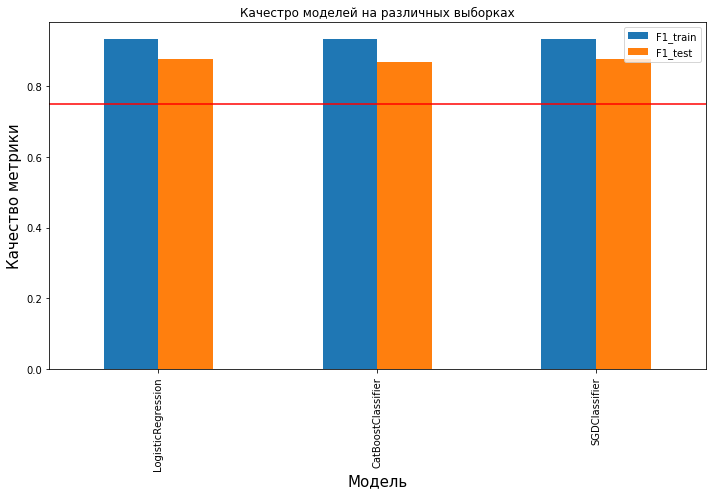

In [20]:
df_score = pd.DataFrame.from_dict(data=test_score, columns=['F1_train', 'F1_test'], orient='index')
display(df_score)

plt.figure(figsize=(10, 7))
plt.subplot(111)
df_score.plot(kind='bar', ax=plt.gca()).hlines(0.75, -1, 5,
                                              color = 'r')
plt.xlabel('Модель', fontsize=15)
plt.ylabel('Качество метрики', fontsize=15)
plt.title('Качестро моделей на различных выборках')

plt.tight_layout()

# 3. Выводы

Сбалансировав исходные данные на выбранных моделях получилось достигнуть заданных параметров метрики качества.



# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны